아직 ETF 티커를 찾을 수 없음

In [40]:
# https://blog.naver.com/okkam76/221286358499
import datetime as dt

In [41]:
import pandas_datareader.data as web

import pandas as pd
import numpy as np
import scipy

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 150

In [42]:
# !pip install pandas_datareader

In [43]:
import pandas_datareader.data as web

In [44]:
def get_price_from_morningstar(ticker):
    start = dt.datetime(2015,1,1) # 시작날짜
    end = dt.datetime.now() # 현재날짜

    df = web.DataReader(ticker, 'stooq', start, end) # STOOQ API 사용
    # df.reset_index(inplace=True) # index 재설정
    # df.set_index('Date', inplace=True) # 날짜행 인덱스 지정
    # df = df.drop("Symbol", axis=1) # 종목코드행 삭제
    
    return df

In [45]:
get_price_from_morningstar('EWY')

,Open,High,Low,Close,Volume
Date,,,,,
2022-05-25,65.420,66.160,65.390,66.030,2680167
2022-05-24,65.780,66.260,65.400,66.120,2934754
2022-05-23,66.760,67.350,66.690,67.130,2670972
2022-05-20,66.340,66.480,65.280,66.120,3717770
2022-05-19,64.660,65.735,64.630,65.470,3652795
...,...,...,...,...,...
2015-01-08,48.581,48.994,48.494,48.845,4124964
2015-01-07,47.648,47.940,47.579,47.912,3635143
2015-01-06,47.420,47.588,47.183,47.316,3275846


In [46]:
tickers = ["EWA",  # iShares MSCI Australia Index ETF
                        "EWO",  # iShares MSCI Austria Investable Mkt Index ETF
                        "EWK",  # iShares MSCI Belgium Investable Market Index ETF
                        "EWZ",  # iShares MSCI Brazil Index ETF
                        "EWC",  # iShares MSCI Canada Index ETF
                        "FXI",  # iShares China Large-Cap ETF
                        "EWQ",  # iShares MSCI France Index ETF
                        "EWG",  # iShares MSCI Germany ETF 
                        "EWH",  # iShares MSCI Hong Kong Index ETF
                        "EWI",  # iShares MSCI Italy Index ETF
                        "EWJ",  # iShares MSCI Japan Index ETF
                        "EWM",  # iShares MSCI Malaysia Index ETF
                        "EWW",  # iShares MSCI Mexico Inv. Mt. Idx
                        "EWN",  # iShares MSCI Netherlands Index ETF
                        "EWS",  # iShares MSCI Singapore Index ETF
                        "EZA",  # iShares MSCI South Africe Index ETF
                        "EWY",  # iShares MSCI South Korea ETF
                        "EWP",  # iShares MSCI Spain Index ETF
                        "EWD",  # iShares MSCI Sweden Index ETF
                        "EWL",  # iShares MSCI Switzerland Index ETF
                        "EWT",  # iShares MSCI Taiwan Index ETF
                        "THD",  # iShares MSCI Thailand Index ETF
                        "EWU",  # iShares MSCI United Kingdom Index ETF
                        "SPY",  # SPDR S&P 500 ETF
                        ]

In [47]:
len(tickers)

24

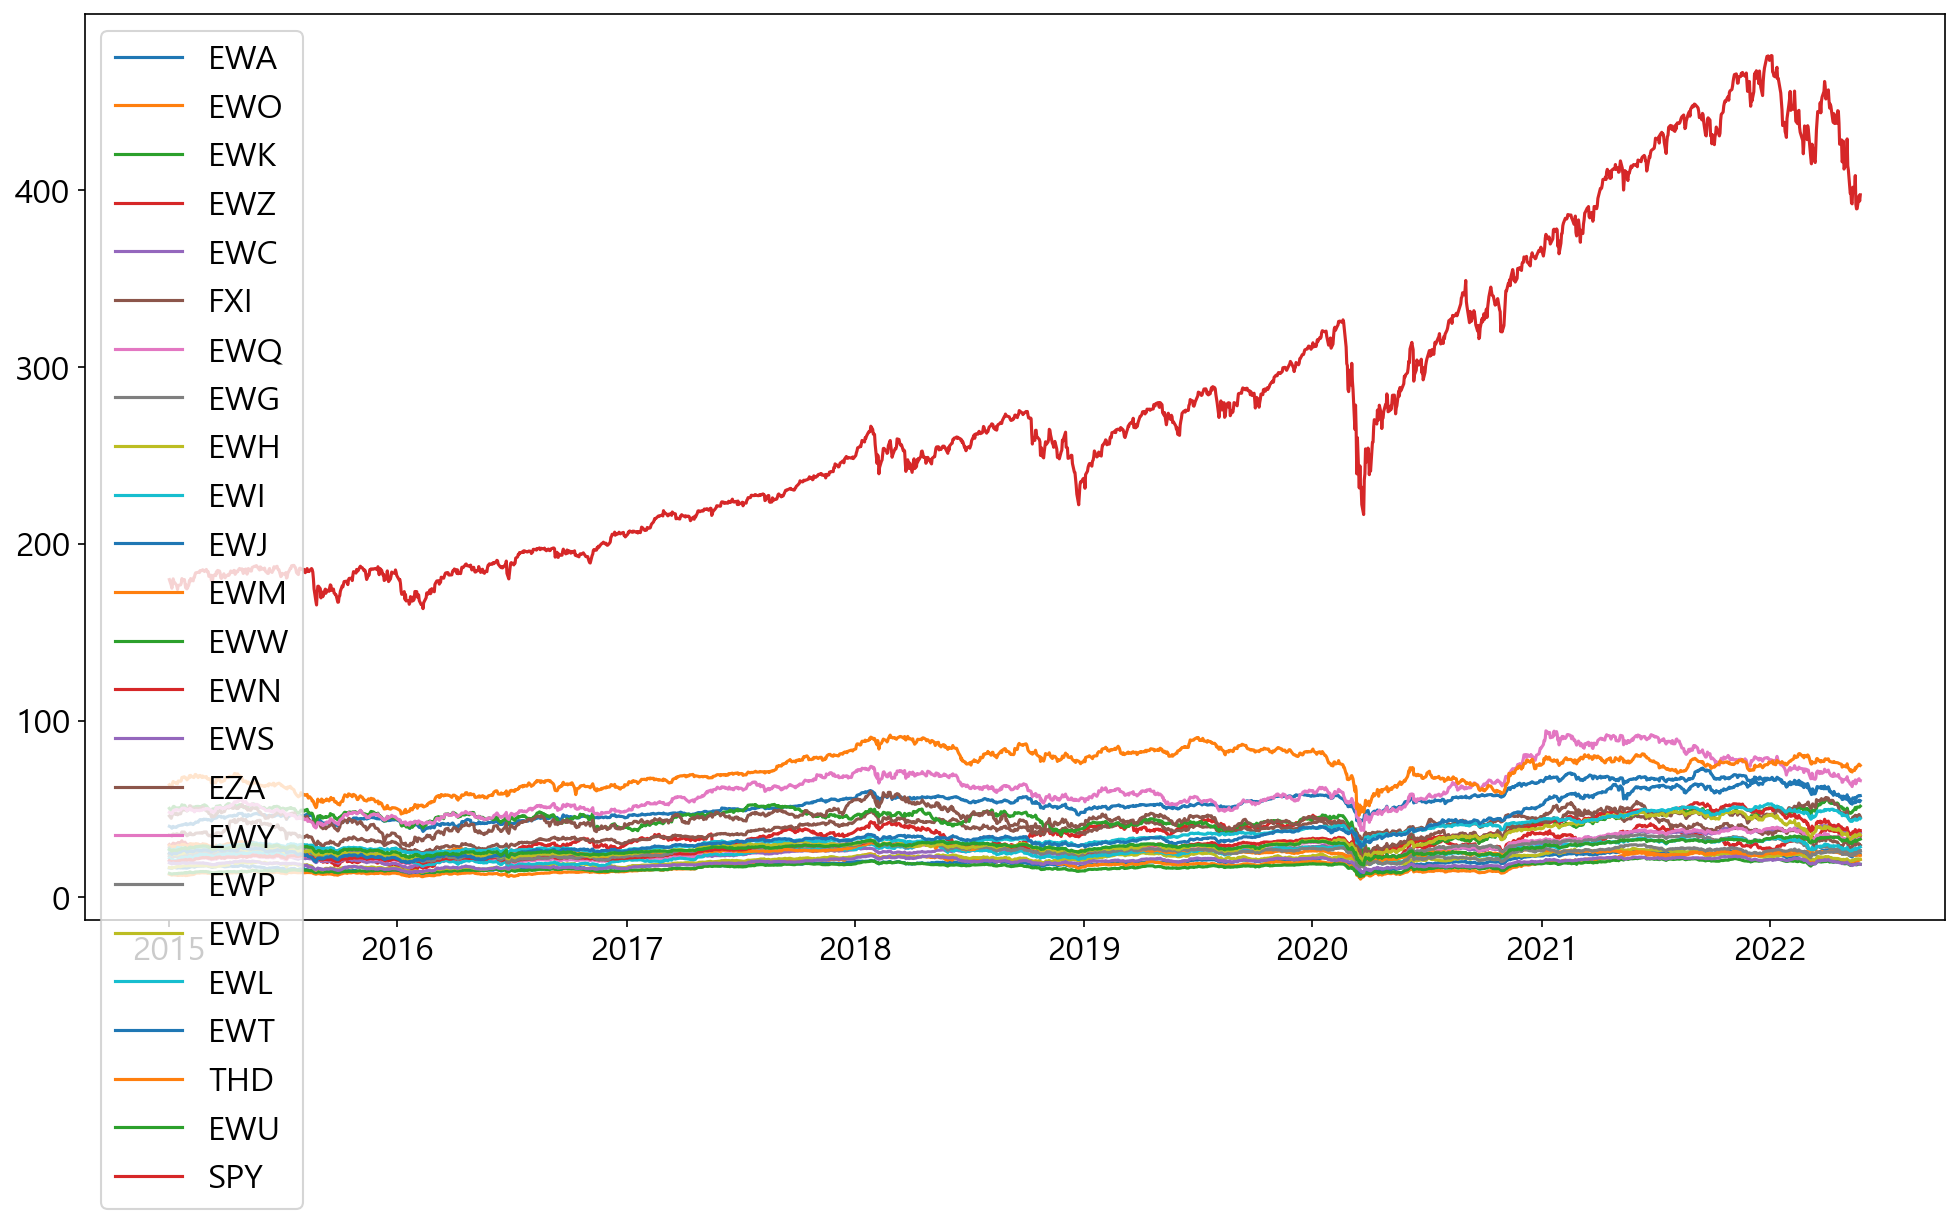

In [48]:
# 종가만 모아보자
# 데이터 시각화
stocks = dict()
legend = []

for ticker in tickers:
    price = get_price_from_morningstar(ticker)
    stocks[ticker] = price['Close'].values[:].tolist()
    legend.append(ticker)

# dict -> Dataframe
prices = pd.DataFrame(stocks)
prices.head()

# index 수정
prices.index = price.index
# prices.head()

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 16
plt.figure(figsize=(16,8))

plt.plot(prices)
plt.legend(legend, loc='upper left')


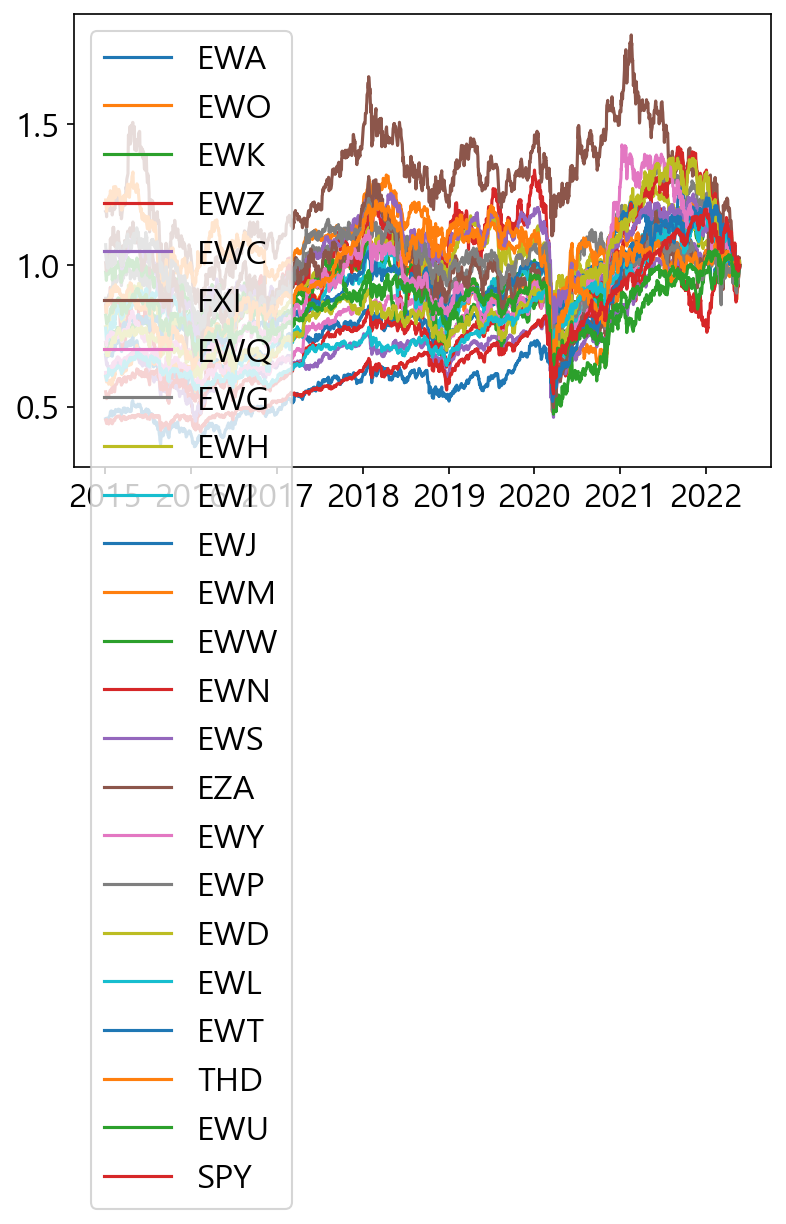

In [49]:
# 누적 수익률로 비교
plt.plot(prices/prices.iloc[0])
plt.legend(legend, loc='upper left')

In [50]:
prices.tail()

,EWA,EWO,EWK,EWZ,EWC,FXI,EWQ,EWG,EWH,EWI,...,EWS,EZA,EWY,EWP,EWD,EWL,EWT,THD,EWU,SPY
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-08,16.830,12.713,13.348,30.670,24.049,35.857,20.271,23.116,16.864,21.284,...,19.474,47.941,48.845,26.287,24.343,27.008,25.085,65.544,26.836,180.20
2015-01-07,16.611,12.730,13.220,30.188,23.754,35.568,19.909,22.686,16.800,21.005,...,19.085,47.129,47.912,26.638,24.245,26.631,24.600,64.637,26.366,177.03
2015-01-06,16.459,12.567,13.147,29.391,23.729,34.656,19.714,22.497,16.487,20.796,...,18.875,45.760,47.316,26.398,24.025,26.459,24.184,62.334,26.139,174.88
2015-01-05,16.526,12.686,13.273,28.875,24.082,35.086,19.933,22.592,16.741,21.022,...,19.099,44.717,47.491,26.847,24.205,26.743,24.684,61.942,26.442,176.53
2015-01-02,16.686,13.088,13.607,29.900,24.749,35.214,20.677,23.408,16.864,22.143,...,19.520,46.035,48.089,28.017,24.887,27.104,25.002,63.714,27.126,179.78


In [51]:
prices.sort_index().head()

,EWA,EWO,EWK,EWZ,EWC,FXI,EWQ,EWG,EWH,EWI,...,EWS,EZA,EWY,EWP,EWD,EWL,EWT,THD,EWU,SPY
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,16.686,13.088,13.607,29.900,24.749,35.214,20.677,23.408,16.864,22.143,...,19.520,46.035,48.089,28.017,24.887,27.104,25.002,63.714,27.126,179.78
2015-01-05,16.526,12.686,13.273,28.875,24.082,35.086,19.933,22.592,16.741,21.022,...,19.099,44.717,47.491,26.847,24.205,26.743,24.684,61.942,26.442,176.53
2015-01-06,16.459,12.567,13.147,29.391,23.729,34.656,19.714,22.497,16.487,20.796,...,18.875,45.760,47.316,26.398,24.025,26.459,24.184,62.334,26.139,174.88
2015-01-07,16.611,12.730,13.220,30.188,23.754,35.568,19.909,22.686,16.800,21.005,...,19.085,47.129,47.912,26.638,24.245,26.631,24.600,64.637,26.366,177.03
2015-01-08,16.830,12.713,13.348,30.670,24.049,35.857,20.271,23.116,16.864,21.284,...,19.474,47.941,48.845,26.287,24.343,27.008,25.085,65.544,26.836,180.20


In [52]:
prices.sort_index(inplace=True)

In [53]:
prices.head()

,EWA,EWO,EWK,EWZ,EWC,FXI,EWQ,EWG,EWH,EWI,...,EWS,EZA,EWY,EWP,EWD,EWL,EWT,THD,EWU,SPY
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,16.686,13.088,13.607,29.900,24.749,35.214,20.677,23.408,16.864,22.143,...,19.520,46.035,48.089,28.017,24.887,27.104,25.002,63.714,27.126,179.78
2015-01-05,16.526,12.686,13.273,28.875,24.082,35.086,19.933,22.592,16.741,21.022,...,19.099,44.717,47.491,26.847,24.205,26.743,24.684,61.942,26.442,176.53
2015-01-06,16.459,12.567,13.147,29.391,23.729,34.656,19.714,22.497,16.487,20.796,...,18.875,45.760,47.316,26.398,24.025,26.459,24.184,62.334,26.139,174.88
2015-01-07,16.611,12.730,13.220,30.188,23.754,35.568,19.909,22.686,16.800,21.005,...,19.085,47.129,47.912,26.638,24.245,26.631,24.600,64.637,26.366,177.03
2015-01-08,16.830,12.713,13.348,30.670,24.049,35.857,20.271,23.116,16.864,21.284,...,19.474,47.941,48.845,26.287,24.343,27.008,25.085,65.544,26.836,180.20


In [54]:
prices.tail()

,EWA,EWO,EWK,EWZ,EWC,FXI,EWQ,EWG,EWH,EWI,...,EWS,EZA,EWY,EWP,EWD,EWL,EWT,THD,EWU,SPY
Date,,,,,,,,,,,,,,,,,,,,,
2022-05-19,23.83,20.34,18.4000,32.82,36.32,30.30,32.69,25.95,21.55,27.60,...,18.80,45.99,65.47,24.72,35.04,43.81,54.12,73.84,31.76,389.46
2022-05-20,24.04,20.37,18.5300,33.62,36.21,30.42,32.68,26.09,21.78,27.56,...,19.03,45.64,66.12,24.96,34.88,43.67,54.34,73.95,32.08,389.63
2022-05-23,24.35,21.02,18.8800,34.84,36.84,30.35,33.43,26.69,21.78,28.20,...,19.00,46.89,67.13,25.57,35.76,44.52,54.92,75.37,32.71,396.92
2022-05-24,24.32,21.21,18.8183,34.78,36.47,29.19,33.32,26.51,21.50,28.26,...,18.70,46.46,66.12,25.91,35.96,44.96,54.05,75.06,32.77,393.89
2022-05-25,24.40,21.40,18.7600,34.75,36.65,29.56,33.30,26.49,21.53,28.47,...,18.69,45.60,66.03,26.10,35.32,44.61,54.68,74.66,32.94,397.43


In [55]:
prices.shift(1)

,EWA,EWO,EWK,EWZ,EWC,FXI,EWQ,EWG,EWH,EWI,...,EWS,EZA,EWY,EWP,EWD,EWL,EWT,THD,EWU,SPY
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,16.686,13.088,13.6070,29.900,24.749,35.214,20.677,23.408,16.864,22.143,...,19.520,46.035,48.089,28.017,24.887,27.104,25.002,63.714,27.126,179.78
2015-01-06,16.526,12.686,13.2730,28.875,24.082,35.086,19.933,22.592,16.741,21.022,...,19.099,44.717,47.491,26.847,24.205,26.743,24.684,61.942,26.442,176.53
2015-01-07,16.459,12.567,13.1470,29.391,23.729,34.656,19.714,22.497,16.487,20.796,...,18.875,45.760,47.316,26.398,24.025,26.459,24.184,62.334,26.139,174.88
2015-01-08,16.611,12.730,13.2200,30.188,23.754,35.568,19.909,22.686,16.800,21.005,...,19.085,47.129,47.912,26.638,24.245,26.631,24.600,64.637,26.366,177.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-19,23.520,19.820,18.5072,32.140,35.910,29.620,32.380,25.560,21.390,27.040,...,18.470,45.020,64.230,24.450,34.300,43.690,53.710,72.890,31.640,391.86
2022-05-20,23.830,20.340,18.4000,32.820,36.320,30.300,32.690,25.950,21.550,27.600,...,18.800,45.990,65.470,24.720,35.040,43.810,54.120,73.840,31.760,389.46
2022-05-23,24.040,20.370,18.5300,33.620,36.210,30.420,32.680,26.090,21.780,27.560,...,19.030,45.640,66.120,24.960,34.880,43.670,54.340,73.950,32.080,389.63


In [56]:
history_prices = prices.shift(1)

In [57]:
import itertools as it

setcash = 100000
period = 120
max_traded_pairs = 5 # the top 5 pairs with the smallest distance are used.

traded_pairs = []
traded_quantity = {}

sorted_pairs = []
symbol_pairs = list(it.combinations(tickers, 2))

In [58]:
len(symbol_pairs)

276

In [59]:
symbol_pairs

[('EWA', 'EWO'),
 ('EWA', 'EWK'),
 ('EWA', 'EWZ'),
 ('EWA', 'EWC'),
 ('EWA', 'FXI'),
 ('EWA', 'EWQ'),
 ('EWA', 'EWG'),
 ('EWA', 'EWH'),
 ('EWA', 'EWI'),
 ('EWA', 'EWJ'),
 ('EWA', 'EWM'),
 ('EWA', 'EWW'),
 ('EWA', 'EWN'),
 ('EWA', 'EWS'),
 ('EWA', 'EZA'),
 ('EWA', 'EWY'),
 ('EWA', 'EWP'),
 ('EWA', 'EWD'),
 ('EWA', 'EWL'),
 ('EWA', 'EWT'),
 ('EWA', 'THD'),
 ('EWA', 'EWU'),
 ('EWA', 'SPY'),
 ('EWO', 'EWK'),
 ('EWO', 'EWZ'),
 ('EWO', 'EWC'),
 ('EWO', 'FXI'),
 ('EWO', 'EWQ'),
 ('EWO', 'EWG'),
 ('EWO', 'EWH'),
 ('EWO', 'EWI'),
 ('EWO', 'EWJ'),
 ('EWO', 'EWM'),
 ('EWO', 'EWW'),
 ('EWO', 'EWN'),
 ('EWO', 'EWS'),
 ('EWO', 'EZA'),
 ('EWO', 'EWY'),
 ('EWO', 'EWP'),
 ('EWO', 'EWD'),
 ('EWO', 'EWL'),
 ('EWO', 'EWT'),
 ('EWO', 'THD'),
 ('EWO', 'EWU'),
 ('EWO', 'SPY'),
 ('EWK', 'EWZ'),
 ('EWK', 'EWC'),
 ('EWK', 'FXI'),
 ('EWK', 'EWQ'),
 ('EWK', 'EWG'),
 ('EWK', 'EWH'),
 ('EWK', 'EWI'),
 ('EWK', 'EWJ'),
 ('EWK', 'EWM'),
 ('EWK', 'EWW'),
 ('EWK', 'EWN'),
 ('EWK', 'EWS'),
 ('EWK', 'EZA'),
 ('EWK', 'EWY'

In [60]:
days = 20

In [61]:
# history_price를 만들어서 그걸 업데이트하고
# 다른건 history_price를 바라보게 하면 편할까?

pairs_to_remove = []

def Distance(price_a, price_b):
    # Calculate the sum of squared deviations between two normalized price series
    norm_a = np.array(price_a) / price_a[-1]
    norm_b = np.array(price_b) / price_b[-1]
    return sum((norm_a - norm_b)**2)

In [62]:
history_prices[symbol_pairs[0][0]].values

array([   nan, 16.686, 16.526, ..., 24.04 , 24.35 , 24.32 ])

In [63]:
history_prices[symbol_pairs[0][0]].values / history_prices[symbol_pairs[0][0]].values[-1]

array([       nan, 0.68610197, 0.67952303, ..., 0.98848684, 1.00123355,
       1.        ])

In [64]:
distances = {}
for pair in symbol_pairs:
    distances[pair] = Distance(history_prices[pair[0]][1:], history_prices[pair[1]][1:])

if len(distances) != 0:
    sorted_pairs = sorted(distances.items(), key=lambda x: x[1])[:max_traded_pairs]

In [65]:
sorted_pairs

[(('EWA', 'EWQ'), 4.712639555626174),
 (('EWT', 'SPY'), 5.665715476815685),
 (('EWK', 'EWJ'), 7.628663463199828),
 (('EWK', 'EWI'), 8.247927093162549),
 (('EWN', 'EWD'), 9.52871327859429)]

In [ ]:
days = 20
if days == 20:
    # pair 재세팅
    # minimize the sum of squared deviations
    distances = {}
    for pair in symbol_pairs:
        distances[pair] = Distance(history_prices[pair[0]], history_prices[pair[1]])
    
    if len(distances) != 0:
        sorted_pairs = sorted(distances.items(), key= lambda x: x[1])[:max_traded_pairs]
        
    # 포지션 청산
    traded_pairs.clear()
    traded_quantity.clear()
    # 보유한 포지션 더 있는지 확인 필요

    days = 0

days += 1

pairs_to_remove = []

for pair in sorted_pairs:
    # spread 계산
    price_a = history_prices[pair[0]]
    price_b = history_prices[pair[1]]



